In [1]:
%matplotlib inline

<div style='display: flex; justify-content: space-between; align-items: center; width: 100%;'>
    <h1 style='flex-grow: 1; margin-right: 120px; white-space: nowrap;'>THESE ARE NOT MY SHEEP YAS YAS YAS SKALEY</h1>
    <img src='https://upload.wikimedia.org/wikipedia/commons/7/78/Eindhoven_University_of_Technology_logo_new.png' alt='tue' style='height: 100px; flex-shrink: 0;'>
</div>

<div>
    <h3>Assignment 3 - Hydraulic Cross Section</h3>
    <p><strong>June 2024</strong></p>
    <p><strong>Ata Bekișoğlu</strong> - <i>1697048</i></p>
</div>


<!-- ya allah send help-->

# Abstract

### Table of Contents

---

# Introduction

---

# Problem Description

The problem at hand is modeling the laminar flow of a viscous fluid through a porous medium (e.g., a sponge) within a long channel. The porous medium is represented by binary images where each pixel is either "open" (allowing fluid flow) or  "closed" (impermeable to fluid flow). My main goal is to quantify the **hydraulic throughput** $ S $, a geometric parameter that remains independent of the fluid properties channel length and pressure drop using the relation:

$$
S = \frac{\mu L Q}{\Delta P}
\tag{1}
$$

Where $ Q $ is the volumetric flow rate, $ \mu $ is the fluid viscosity, $ L $ is the channel length, and $ \Delta P $ is the pressure drop. My task is to predict $ S $ from the binary cross-sectional images from the porous medium. 

---

# Making Sense of the Data
In this section, I  aim to explore the dimensional properties of the data, generate visualizations to aid with the general understanding of the problem at hand and explore the statistical properties that might help build better neural networks. 

The dataset consists of two `.npy` ([NumPy](https://numpy.org/)) files with $ N = 1660 $ samples of $ 40 \times 40 $ pixel area images and hydraulic throughput $ S $ targets.

In [2]:
import numpy as np

X = np.load("data/pub_input.npy")
y = np.load("data/pub_out.npy")
print(X.shape, y.shape)

(1660, 40, 40) (1660,)



## Dimensionality, Homogeneity and Scaling
### Dimensionality
Dimensional homogeneity ensures that the quantities are consistent in terms of their SI units. Here, I analyze the dimensionality of the problem, apply scaling, and ensure homogeneity to accurately predict hydraulic throughput. The  variables in the problem have the following dimensions in SI units:
- Volumetric flow rate $ Q $, is measured in cubic meters per second [$ m^3s^{-1} $].
- Pressure drop $ \Delta P $, is measured in Pascals ($ Pa $), also equivalent to [$ kg \cdot m^{-1} \cdot s^{-2} $].
- Channel length $ L $, is measured in meters [$ m $].
- Fluid viscosity $ \mu $ is measured in Pascal-seconds ($ Pa \cdot s $) which is equivalent to [$ kg \cdot m^{-1} \cdot s^{-1} $].
- **Pixel area $ A $ is measured in square meters [$ m^2 $]**.
- **The hydraulic throughput $ S $ is calculated using (1) which gives**:

$$
S = \frac{
[kg \cdot m^{-1} \cdot s^{-1}] \cdot [m] \cdot [m^3 \cdot s^{-1}]}
{[kg \cdot m^{-1} \cdot s^{-2}]} = [m^4]
\tag{2}
$$

### Scaling
To make the fitting problem 1-degree homogeneous the target variable $ S $ is scaled by the square root to reduce its SI unit from $ m^4 $ to $ m^2 $. This ensures that the units of the target variable align with the input image units. 
$$
S_i' = \sqrt{S_i}
\tag{3}
$$
To apply this logic in Python:

In [3]:
y = np.sqrt(y)

## Visualizing the Problem
To better understand the dataset, several visualizations are performed, including visualizing some of the binary cross-section images along with their corresponding hydraulic throughput values, distribution of $ S $, and a density plot.

The basic properties of the hydraulic throughput:

In [4]:
print(f'Min: {np.min(y):0.2f}, \
        Max: {np.max(y):0.2f},\
        Mean: {np.mean(y):0.2f}, \
        Standard Deviation: {np.std(y):0.2f}, \
        Correlation Between Consecutive S: {np.corrcoef(y[:-1], y[1:])[0, 1]:0.2f}')

Min: 2.65,         Max: 554.82,        Mean: 110.99,         Standard Deviation: 144.51,         Correlation Between Consecutive S: 0.40


The hydraulic throughput values are spread out, with many values clustered around lower values indicated by the mean. The high standard deviation suggests substantial variability in the hydraulic throughput across different images. There is also a small amount of positive correlation between consecutive throughputs of cross-sections $ ( S_i - S_{i-1}) $ meaning there is a small influence between consecutive cross-sections. 



And, for the areas (total area per image):

In [5]:
total_area = X.sum(axis=(1, 2))
print(f'Min: {np.min(total_area):0.2f}, \
        Max: {np.max(total_area):0.2f},\
        Mean: {np.mean(total_area):0.2f}, \
        Standard Deviation: {np.std(total_area):0.2f}')

Min: 7.00,         Max: 1435.00,        Mean: 384.02,         Standard Deviation: 409.31


The total open area per image varies widely, indicating diverse cross-section porosity levels. The mean area of 384.02 pixels suggests that, on average, about half of the pixels in the images are open. The high standard deviation reflects significant heterogeneity in the distribution of open areas across the images.

**Binary Cross-Section Images**:

The first 5 examples from `X` are plotted and annotated with their corresponding hydraulic throughput $ S' $. Cross-sections are denoted in $ CS $.

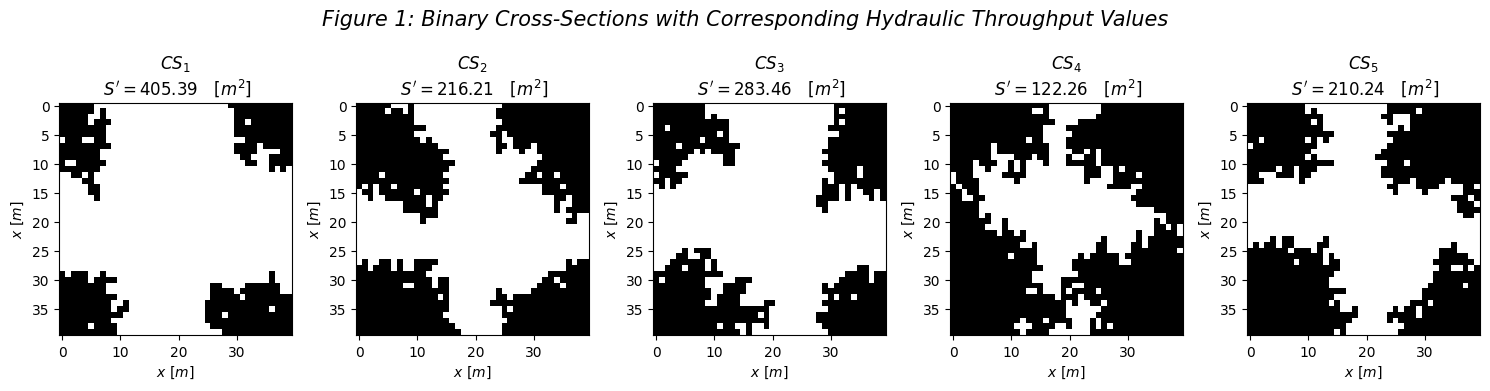

In [6]:
import matplotlib.pyplot as plt

def plot_image(ax, image, index, add=None):
    ax.imshow(image, cmap='gray')
    ax.set_title(f"$ CS_{{{index + 1}}} $ {add or ''}\n $ S' = {y[index]:.2f} \quad [m^2] $ ")  # oh god
    ax.set_xlabel('$ x \ [m] $')
    ax.set_ylabel('$ x \ [m] $')

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    plot_image(axes[i], X[i], i)

plt.suptitle('Figure 1: Binary Cross-Sections with Corresponding Hydraulic Throughput Values', fontsize=15, style='italic')
plt.tight_layout()
plt.show()


*Figure 1* shows five examples of open (white) and closed (black) pixels affecting the hydraulic throughput $ S $. Cross-sections with more continuous pathways for fluid flow tend to have higher $ S $ values, indicating greater hydraulic throughput.

**Distribution of Hydraulic Throughput Values & Density Plot of Hydraulic Throughput vs. Number of Open Pixels**:

A histogram is plotted to visualize the distribution of hydraulic throughput values (Figure 2). Additionally, the number of open pixels and how they correspond to $ S $ values is plotted (Figure 3) in a density plot.

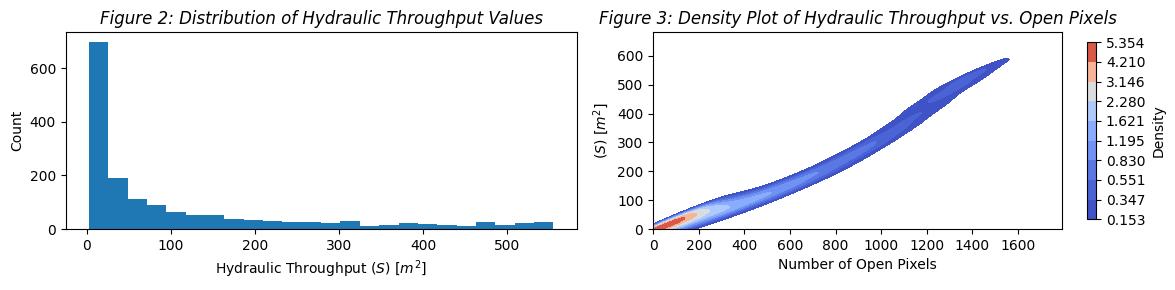

In [7]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# histogram of hydraulic throughput values
axes[0].hist(y, bins=24)
axes[0].set_xlabel('Hydraulic Throughput ($S$) $[m^2]$')
axes[0].set_ylabel('Count')
axes[0].set_title('Figure 2: Distribution of Hydraulic Throughput Values', style='italic')

# hydraulic throughput vs. number of open pixels
dp = sns.kdeplot(x=total_area, y=y, cmap='coolwarm', fill=True, ax=axes[1])
axes[1].set_xlabel('Number of Open Pixels')
axes[1].set_ylabel('($S$) $[m^2]$')
axes[1].set_title('Figure 3: Density Plot of Hydraulic Throughput vs. Open Pixels', style='italic')
axes[1].set_xlim(0)
axes[1].set_ylim(0)
plt.colorbar(dp.collections[-1], ax=axes[1], label='Density', shrink=0.9).ax.yaxis.offsetText.set_visible(False)

plt.tight_layout()
plt.show()

*Figure 2* shows that most hydraulic throughput $ S $ values are concentrated at the lower end. This indicates that higher $ S $ values are less frequent suggesting that many cross-sections have limited pathways for fluid flow, leading to lower hydraulic throughput.

*Figure 3* shows a positive correlation between the number of open pixels and hydraulic throughput. The highest density of points is around lower open pixel counts and lower $ S $ values, indicating that most cross-sections have fewer open pixels and consequently lower hydraulic throughput. As the number of open pixels increases, $ S $ also increases implying that cross-sections with more open pixels provide more continuous pathways for fluid flow, resulting in higher hydraulic throughput. The concentration of lower $ S $ values in *Figure 2* aligns with the scatter plot, indicating that many images have fewer open pixels, hence lower hydraulic throughput.

---

# Exploring Symmetries in the Problem
Understanding the symmetries of the problem is key to designing an effective neural network model. Here, each symmetry is analyzed to determine which ones can be used while preserving the integrity of the white (open) pixel clusters. These symmetries are then discussed on whether they can be used for data augmentation or not.
<!-- 
Invariance refers to transformations applied to the input data ($A_1, A_2,...,A_N$) that do not change the output ($S_{i}$)[$^{[1]}$](https://www.mathsisfun.com/definitions/invariant.html)[$^{[2]}$](https://encyclopediaofmath.org/wiki/Invariant). To explore the invariance properties a set of problem specific criteria must be laid out: -->

Mathematically, symmetries can be described by groups. A relationship between a function (such as a neural network layer) and a symmetry group by considering its *equivariance* properties. A map $f$: $X \rightarrow Y$ is said to be equivariant with respect to the actions $\rho$: $ G \times X \rightarrow X$ and $\rho'$: $ G \times Y \rightarrow Y $ of a group $ G $ on $X$ and $Y$ if[$^{[6]}$](https://arxiv.org/pdf/2203.06153):

$$
f(\rho_g(x) ) = \rho'_g(f(x))
\tag{4}
$$

For this property to hold a set of problem specific criteria must be laid out:


1. After any transformation the number of white pixels must remain constant in the image.
2. The correlation analysis in [Visualizing the Problem](asd) indicates a small positive correlation between consecutive cross-sections. Any transformation should maintain this property.
3. White pixel clusters in the images represent large regions in which fluid can flow through the porous medium. These clusters are important for determining the hydraulic throughput as they form the pathways through which liquid can flow (*Figure 4*). Any transformation applied to the image must preserve the structure of the clusters. 

<div style="text-align: center;">
    <img src="fig/clusters.png" alt="Figure 4: Open pixel clusters for hydraulic throughput" width="300">
    <p style="text-align: center;"><i>Figure 4: Open pixel clusters for hydraulic throughput</i></p>
</div>




To serve as a safeguard for each transformation the `count_pixels()` method is implemented:

In [58]:
def count_pixels(original_img, transformed_img):
    c_original, c_transformed =  np.sum(original_img), np.sum(transformed_img)
    assert c_original == c_transformed, f'White pixel count not preserved! {c_original} != {c_transformed}'

### Rotational Symmetry ($ R $)
Rotational symmetry involves rotating the image by $ 90\degree $, $ 180\degree $, and $ 270\degree $. This transformation preserves both the white pixel count and the clusters. These transformations can be seen in *Figure 5*. This symmetry is adequate for use in data data augmentation. 

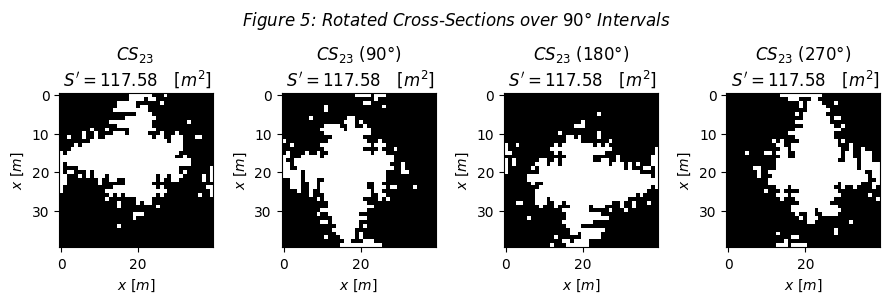

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(11, 2))
plot_image(axes[0], X[22], 22)
plot_image(axes[1], np.rot90(X[22]), 22, add='($90\degree$)')
plot_image(axes[2], np.rot90(X[22], 2), 22, add='($180\degree$)')
plot_image(axes[3], np.rot90(X[22], 3), 22, add='($270\degree$)')

plt.suptitle('Figure 5: Rotated Cross-Sections over $ 90\degree $ Intervals', fontsize=12, style='italic', y=1.3)
plt.show()

### Flip Symmetry ($M$)
Flip symmetry involves flipping the image either horizontally on the $ x $-axis ($ M_x $) or vertically on the $ y $-axis ($ M_y $) seen in *Figure 6*. This transformation is significant as it maintains the relative positions and connectivity of the white pixel clusters, making sure that the fluid pathways are preserved. Similar to the rotational symmetry this method can also be used for data augmentation.

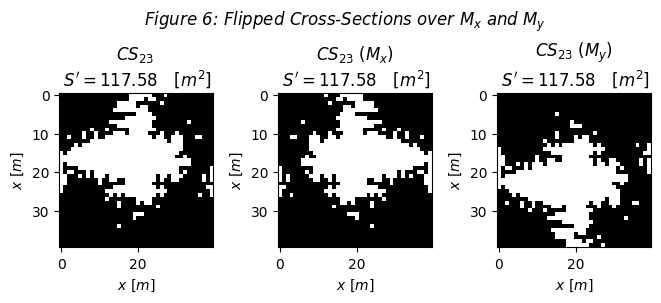

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2))
plot_image(axes[0], X[22], 22)
plot_image(axes[1], np.fliplr(X[22]), 22, add='($M_x$)')
plot_image(axes[2], np.flipud(X[22]), 22, add='($M_y$)')

plt.suptitle('Figure 6: Flipped Cross-Sections over $M_x$ and $M_y$', fontsize=12, style='italic', y=1.3)
plt.show()

### Translational Symmetries ($ T $)

Translational symmetry involves shifting the image in various directions and two dimensions, $ T_x $ and $ T_y $. This can be done using two approaches: wrapping or padding.
- **Wrapping**: This method revolves around shifting pixels from one end of the image to the opposite side. Wrapping is not a valid method since it might disrupt the connectivity of open pixel clusters.
- **Padding**: Adding padding (extra black pixels) to the image to allow for shifts without losing white pixels. This implementation is also invalid since it changes the image size making it incompatible with the fixed input size expected by the neural network.

Translational symmetries cannot be used for data augmentation because the two approaches violate the invariance criteria. However, Convolutional Neural Networks (CNNs) inherently possess properties that handle translational symmetries. This is explored further in [Equivariance Properties of CNNs]().


### General Permutations
General permutations involve arbitrary rearrangement of pixels within the image. This transformation disrupts the structure and connectivity of white pixel clusters, leading to significant changes in the image (*Figure 7*). Hence this method is also deemed invalid.


<div style="text-align: center;">
    <img src="fig/og_vs_perm.png" alt="Figure 7: ya allah" width="600">
    <p style="text-align: center;"><i>Figure 7: Original Cross-Section vs. Random Permutation</i><br> Original image (left) with calculated hydraulic throughput vs. randomly permuted image (right), showing the invalidity of general permutations due to loss of structural integrity.</p>
</div>



### Combined Symmetries ($ R \times M $)
The combined symmetries of rotations and flip symmetries can be described by the direct product of rotation group $ R $ and the flip reflection group $ M $. These combined symmetries belong to the dihedral group $ D_4 $ which is the symmetry group of the square[$^{[3]}$](https://proofwiki.org/wiki/Definition:Dihedral_Group_D4), resulting in 8 unique transformations (*Table 1*).

<div style="text-align: center;">


|      | $Id$   | $R_{90}$ | $R_{180}$ | $R_{270}$ | $M_x$   | $M_y$   |
|------|----------|------------|-------------|-------------|-----------|-----------|
| $\mathbf{Id}$   | $Id^*$ | $R_{90}^*$  | $R_{180}^*$  | $R_{270}^*$  | $M_x^*$ | $M_y^*$ |
| $\mathbf{M_x}$ | $M_x$ | $M_x \cdot R_{90}^*$ | $R_{180}$ | $M_x \cdot R_{270}^*$ | $Id$   | $R_{180}$   |
| $\mathbf{M_y}$ | $M_y$ | $M_y \cdot R_{90}$ | $R_{180}$ | $M_y \cdot R_{270}$ | $R_{180}$ | $Id$       |


<p style="text-align: center;"><i>Table 1: All possible transformations and their combinations for Identity ($Id$), Rotation ($R$), and Flip ($M$). <br> *: Unique transformations, 8 in total.
</i></p>

</div>


---

# Symmetries and Convolutional Neural Networks
Deep Learning techniques, particularly convolutional neural networks (CNNs), have achieved significant success in processing image-based data, where the data presents a well-defined structure in the regular grid of pixels[$^{[4]}$](https://arxiv.org/pdf/1803.05419). The name “convolutional neural network” indicates that the network employs a mathematical operation called convolution (*Figure 8*). *Convolution is a specialized kind of linear operation. Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.*[$^{[5]}$](https://www.deeplearningbook.org/contents/convnets.html)

<div style="text-align: center;">
    <img src="fig/conv_subset.png" alt="Figure 8: ya allah" width="400">
    <p style="text-align: center;"><i>Figure 8: Convolutional Operation Applied on a Cross-Section </i> <br>
    In the image a $ 4 \times 4$ convolutional filter is applied to a $6 \times 6$ subset of the cross-section, resulting in a $3 \times 3$ output grid.  
    </p>
</div>

Convolution in CNNs incorporates a sliding filter (kernel, seen in the left red box in *Figure 8* ), across the input image and computing the dot products between the filter and the overlapping regions of the input. For an input $ I $ and a filter $ K $, the convolution operation $S_c$ at position $ (i, j) $ is given by[$^{[5]}$](https://www.deeplearningbook.org/contents/convnets.html):

$$
S_c(i, j) = \sum_m \sum_n I(i+m,j+n) \cdot K(m,n)
\tag{5}
$$

This generates a feature map (right red box in *Figure 8*) that highlights the important features such as edges and patterns. By stacking convolutional layers, CNNs learn hierarchical feature representations: lower levels capture simple features, while higher layers detect complex patterns. CNNs can process multiple channels, for example, RGB images have three channels for red, green, and blue. In the context of my images, only a single channel is used since the images are binary.

## Equivariance Properties of CNNs
Convolutional neural networks (CNNs) exhibit a key property known as equivariance, particularly translation equivariance. This means that if the input image is translated, the output feature maps are correspondingly translated. *This property allows CNNs to effectively recognize patterns regardless of their position in the input image, making them highly suitable for tasks in computer vision where object detection and recognition are paramount[$^{[4]}$](https://arxiv.org/pdf/1803.05419)*. 

The translation equivariance of CNNs comes from the convolution operation, where filters are applied uniformly across the entire spatial dimension of the input. As a result, features detected by these filters maintain their relative spatial relationships even when the input image is shifted. CNN layers are not invariant, but rather preserve discrete translation symmetries at each layer; if the input image is shifted by a certain number of
pixels, the output of the CNN layer (ignoring boundary effects) is shifted by a corresponding amount[$^{[6]}$](https://arxiv.org/pdf/2203.06153).

On the other hand, rotational and reflectional symmetries are not inherent to CNNs, meaning that there is a need for 'pushing' the model to learn these representations. This can be achieved by (1) data augmentation, (2) disambiguation, or (3) specialized network designs[$^{[7]}$](https://www.baeldung.com/cs/translation-invariance-equivariance). 


## Data Augmentation
As previously stated, CNNs are inherently translation equivariant due to the convolutional operation, other symmetries such as the rotations and the flips are not accounted for out of the box. By artificially expanding the training dataset with transformed versions of the original data, the model is exposed to a greater variety of data, enabling the model to learn more invariant and extensive features.

The data augmentation method `augment()` takes in an image and generates all possible transformations from *Table 1*. This function also utilizes the `count_pixels()` method defined above to make sure the criteria is met. In Python:

In [39]:
def augment(image):
    transformations = [
        lambda x: x,  # original image 
        lambda x: np.rot90(x, 1), lambda x: np.rot90(x, 2), lambda x: np.rot90(x, 3),  # r90, r180, r270
        np.fliplr, np.flipud,  # flip x, y
        lambda x: np.flipud(np.rot90(x, 1)), lambda x: np.flipud(np.rot90(x, 3))  # # flip X+r90, flip X+r270
    ]
    X_aug = [transform(image) for transform in transformations]

    return [count_pixels(image, img) or img for img in X_aug]  # call count_pixels() to make sure the criteria is still met!


Then, the `augment()` method is expanded to be applied on the entire dataset. It is observed from the print statement that the dataset is now 8 times its original size.

In [43]:
X_aug = np.array([aug_img for img in X for aug_img in augment(img)])
y_aug = np.array([target for target in y for _ in range(len(augment(X[0])))])

print(f'Original dataset shape: {X.shape}, Augmented dataset shape: {X_aug.shape}')

Original dataset shape: (1660, 40, 40), Augmented dataset shape: (13280, 40, 40)


## Disambiguation
In contrast to data augmentation, data disambiguation is the process of transforming data into its canonical form, this ensures consistency by reducing variability in the data. In the context of the problem, disambiguation helps in standardizing the representation of cross-section images so that the neural network can learn more effectively without being confused by different symmetrical versions of the same image. 

Given an image $X$, a set of all possible transformations $\mathcal{T}$ is applied (6). The goal is to find the canonical from $X_{canonical}$ among all of these transformations.

$$
\mathcal{T}(X) = \{ t(X) \mid t \in \text{Transformations}\}
\tag{6}
$$

The canonical form $X_{canonical}$ is then defined as the transformation that *minimizes* the lexicographical order of the byte representation of the image[$^{[8]}$](https://dmrocke.ucdavis.edu/Class/EAL205C/Canonical.pdf#:~:text=URL%3A%20https%3A%2F%2Fdmrocke.ucdavis.edu%2FClass%2FEAL205C%2FCanonical.pdf%0AVisible%3A%200%25%20) [$^{[9]}$](https://en.wikipedia.org/wiki/Lexicographic_order):

$$
X_{canonical} = \arg\min_{t \in \mathcal{T}} \text{bytes(t(X))}
\tag{7}
$$

This is implemented within the `disambiguate()` function:

In [57]:
def disambiguate(image):
    transformations = augment(image)  # generate T, Equation 6
    return min(transformations, key=lambda t: t.flatten().tobytes())  # return X_canonical, Equation 7

# and, applying to the entire dataset:
X_disambiguated = [disambiguate(img) for img in X]
y_disambiguated = y  # to have consistency among the variables, pass the values of y to y_disam...

## Discussion on Data Augmentation and Disambiguation

Data augmentation increases the variety and robustness of the dataset by introducing rotations and flips, which enhances the model's generalization capabilities. However, it also significantly enlarges the dataset size, leading to longer training times and higher computational demands. Additionally, it may introduce redundancy, as the same structure appears in multiple orientations, and could potentially lead to overfitting if not managed properly.


Data disambiguation ensures consistent data representation by standardizing each unique structure into a canonical form, which reduces dataset size and improves model efficiency by focusing on essential features. Despite these benefits, disambiguation is more complex and computationally intensive to implement, requiring additional steps to determine the canonical form. This process may also reduce the model's ability to recognize symmetries directly from the data.

Given the dataset size and project requirements, data augmentation is selected as the preferred method as the method enhances the model's robustness and generalization capabilities.



<div style="text-align: center;">


| **Method**              | **Pros**                                          | **Cons**                                                      |
|-------------------------|---------------------------------------------------|---------------------------------------------------------------|
| **Data Augmentation**   | - Increases data variety and robustness           | - Enlarges dataset size                                       |
|                         | - Improves generalization                         | - Leads to longer training times                              |
|                         | - Easy to implement                               | - Potential for overfitting                                   |
| **Data Disambiguation** | - Ensures consistent data representation          | - More complex and computationally intensive                  |
|                         | - Reduces dataset size                            | - May reduce model's ability to recognize symmetries          |
|                         | - Improves model efficiency                       | - Requires careful selection of canonical form                |

<p style="text-align: center;"><i>Table 2: Pros and cons of data augmentation and disambiguation.
</i></p>

</div>


# BUILDING THE NN LESGOOOO!

In [60]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Reproducability bit
np.random.seed(5); torch.manual_seed(5)
os.environ['PYTHONHASHSEED'] = '5'

torch.__version__

'2.2.2+cu121'

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running PyTorch on: {device}")

if torch.cuda.is_available():
    device_id = torch.cuda.current_device()
    print(torch.cuda.get_device_name(device_id))
    print(f'Allocated Memory {torch.cuda.memory_allocated(device_id)}')
    print(f'Reserved Memory {torch.cuda.memory_reserved(device_id)}')
    

Running PyTorch on: cuda
NVIDIA GeForce RTX 4060 Laptop GPU
Allocated Memory 0
Reserved Memory 0


In [52]:
class SpongeData(Dataset):
    def __init__(self, X, y):       
        self.features = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)  # pass the data/tensors onto CPU or CUDA and unsqueeze
        self.targets = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)
    
    def __len__(self):
        return self.features.size()[0]
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

def to_torch(X, y, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

    train = SpongeData(X_train, y_train)
    test = SpongeData(X_test, y_test)
    
    return train, test

train_dataset, test_dataset = to_torch(X, y)
print(f'Shape of features: {train_dataset.features.shape}')
print(f'Shape of targets: {train_dataset.targets.shape}')

Shape of features: torch.Size([1328, 1, 40, 40])
Shape of targets: torch.Size([1328, 1])


In [17]:
class RMSPE(nn.Module):
    def __init__(self):
        super(RMSPE, self).__init__()

    def forward(self, y_pred, y_true):
        return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2))

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 20 * 20, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 1, bias=False)
        )

    def forward(self, x):
        return self.model(x)

In [50]:
class EarlyStopping:
    def __init__(self, tolerance=30):
        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False

    def __call__(self, best_loss, val_loss):
        if (self.tolerance > 0) and (best_loss < val_loss):
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            self.counter = 0


def plot_losses_and_predictions(train, test, y_test=None, y_pred=None, lab1='Train', lab2='Test'):
    if isinstance(train, torch.Tensor):
        train = train.cpu().numpy()
    if isinstance(test, torch.Tensor):
        test = test.cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    # plot_losses from the lab notebooks
    axs[0].semilogy(train, label=lab1, marker='.')
    axs[0].semilogy(test, label=lab2, marker='.')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (CHANGE THIS)')
    axs[0].legend()
    axs[0].set_title('Training and Testing Losses')

    if y_test is not None:
        # actual vs predicted scatter plot
        axs[1].scatter(y_test, y_pred, label='Predictions')
        axs[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='ideal fit')
        axs[1].set_xlabel('Actual')
        axs[1].set_ylabel('Predicted')
        axs[1].legend()
        axs[1].set_title('Actual vs Predicted $S$')
    else:
        axs[1].set_visible(False)

    plt.tight_layout()
    plt.show()

In [20]:
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm  # for the beautiful progress bar
# from tqdm import tqdm

def train(train_dataset, val_dataset, model, loss_fn=RMSPE(), num_epochs=50, batch_size=128, learning_rate=1e-3, early_stop=50,verbosity=-1, use_pbar=True):
    # prepare the data - setting num_workers>0 in Jupyter breaks everything...
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # ---- Initialize variables of interest and history ----- #
    train_hist, val_hist = [], []

    best_loss = np.inf
    best_weights = None

    # ----- Initialize the methods ------- # 
    early_stopper = EarlyStopping(tolerance=early_stop)  # initialize the early stopping logic
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # ADAM optimizer
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  # actively updating the leatning rate

    # ----- Get the model ready ----- #
    model.to(device)  # pass it onto CUDA or CPU
    model.train()
    scaler = GradScaler()  # CUDA automatic gradient scaling
    
    # ----- Training ----- #
    tqdm_pbar = tqdm(range(num_epochs), desc='Initializing') if use_pbar else range(num_epochs)  # progress bar

    for epoch in range(num_epochs):
        train_loss, val_loss = 0.0, 0.0
     
        for i, (X_batch, y_batch) in enumerate(train_loader, 0):  # cite to the pytorch documentation
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # pass the tensors to cuda

            optimizer.zero_grad()  # main forward pass
            with autocast():
                y_pred = model(X_batch)
                
                loss = loss_fn(y_pred, y_batch)
                # loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            scaler.scale(loss).backward()  # backward pass
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        # ----- Validation ----- #
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                
                loss = loss_fn(y_pred, y_batch)
                # loss = loss_fn(y_pred, y_batch.unsqueeze(1))
                
                val_loss += loss.item()
        model.train()

        # Get the losses & store
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_hist.append(train_loss)
        val_hist.append(val_loss)

        scheduler.step(val_loss)  # update learning rate
        
        # ------- EarlyStopping -------#
        if val_loss < best_loss:  # getting the best model alongside early stopping
            best_loss = val_loss
            best_weights = model.state_dict()

        early_stopper(best_loss, val_loss)
        if early_stopper.early_stop:
            print(f'Early stopping at epoch {epoch}, validation loss: {val_loss:.8f}')
            break


        # -------- Printing --------- #
        if (verbosity > 0) and (epoch % verbosity == 0):
            print(f"Epoch [{epoch}/{num_epochs}] Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}")
        
        if use_pbar:
            tqdm_pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}")
            tqdm_pbar.update(1)


    # ------- Returning best model --------
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print(f'Returning the best model with validation loss: {best_loss:.4f}')

    # return (best) model parameters alongside train & val history
    return {
        'model': model,
        'train_hist': train_hist,
        'val_hist': val_hist,
    }


def predict(model, validation_tensor):
    with torch.no_grad():
        y_pred = model(validation_tensor.to(device))
        y_pred = y_pred.detach().cpu().numpy()
        return y_pred

In [21]:
class ApplySymmetry(nn.Module):
    def __init__(self):
        super(ApplySymmetry, self).__init__()

    def forward(self, x):
        rotations = [torch.rot90(x, k, [2, 3]) for k in range(4)]
        flips = [torch.flip(x, [2]), torch.flip(x, [3])]
        flip_rotations = [torch.flip(torch.rot90(x, k, [2, 3]), [2]) for k in [1, 3]]
        symmetries = rotations + flips + flip_rotations
        return torch.stack(symmetries, dim=1)

In [33]:
class ConvNet(nn.Module):
    def __init__(self, pad=1):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=pad, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=pad, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=pad, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, x):
        batch_size, sym_count, channels, height, width = x.size()
        x = x.view(batch_size * sym_count, channels, height, width)  # Merge batch and symmetry dimensions
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.gap(x)
        x = x.view(batch_size, sym_count, -1)  # Split batch and symmetry dimensions
        return x


In [34]:
class GroupAverage(nn.Module):
    def __init__(self):
        super(GroupAverage, self).__init__()

    def forward(self, x):
        return x.mean(dim=1)  # Average over symmetry dimension


In [35]:
def make_model(pad=1):
    return nn.Sequential(
        ApplySymmetry(),
        ConvNet(pad=pad),
        GroupAverage(),
        nn.Linear(64, 32, bias=False),
        nn.ReLU(),
        nn.Linear(32, 1, bias=False)
    )

In [36]:
results = dict()

Initializing:   0%|          | 0/200 [00:00<?, ?it/s]

Returning the best model with validation loss: 0.0546


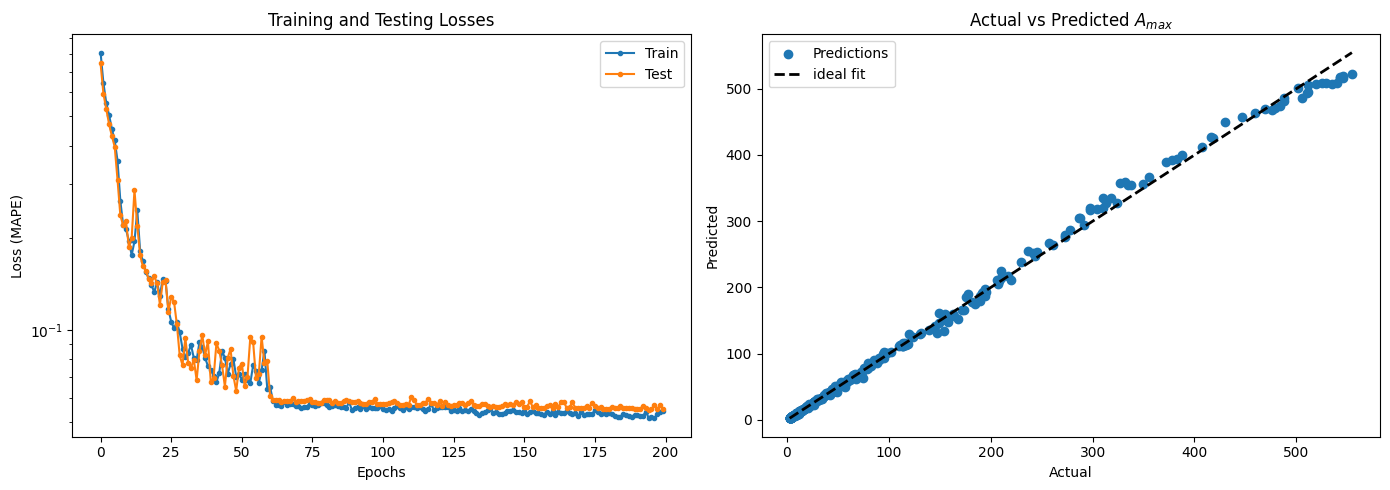

In [40]:
model_name = 'sym_cnn'
results[model_name] = train(train_dataset, test_dataset,
                                model=make_model(pad=1),
                                loss_fn=RMSPE(),
                                num_epochs=200,
                                batch_size=128,
                                learning_rate=1e-2,
                                early_stop=-50,
                                verbosity=-1)

results[model_name]['y_pred'] = predict(results[model_name]['model'], test_dataset.features)

plot_losses_and_predictions(results[model_name]['train_hist'], results[model_name]['val_hist'],
                            test_dataset.targets, results[model_name]['y_pred'])

**200 Epochs, 128 Batch Size, LR=1e-2**
- Pad=1: 0.0398
- Pad=2: 0.0385
- Pad=0: 

In [48]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        batch_size, sym_count, channels, height, width = x.size()
        x = x.view(batch_size * sym_count, channels, height, width)  # Merge batch and symmetry dimensions
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(torch.relu(x))
        x = torch.relu(self.conv3(x))
        x = self.pool(torch.relu(x))
        x = x.view(batch_size, sym_count, -1)  # Split batch and symmetry dimensions
        return x


def make_model2():
    return nn.Sequential(
        ApplySymmetry(),
        ConvNet2(),
        GroupAverage(),
        nn.Linear(64 * 10 * 10, 32, bias=False),  # Adjust input size to match ConvNet2 output
        nn.ReLU(),
        nn.Linear(32, 1, bias=False)
    )


Initializing:   0%|          | 0/200 [00:00<?, ?it/s]

Returning the best model with validation loss: 0.0480


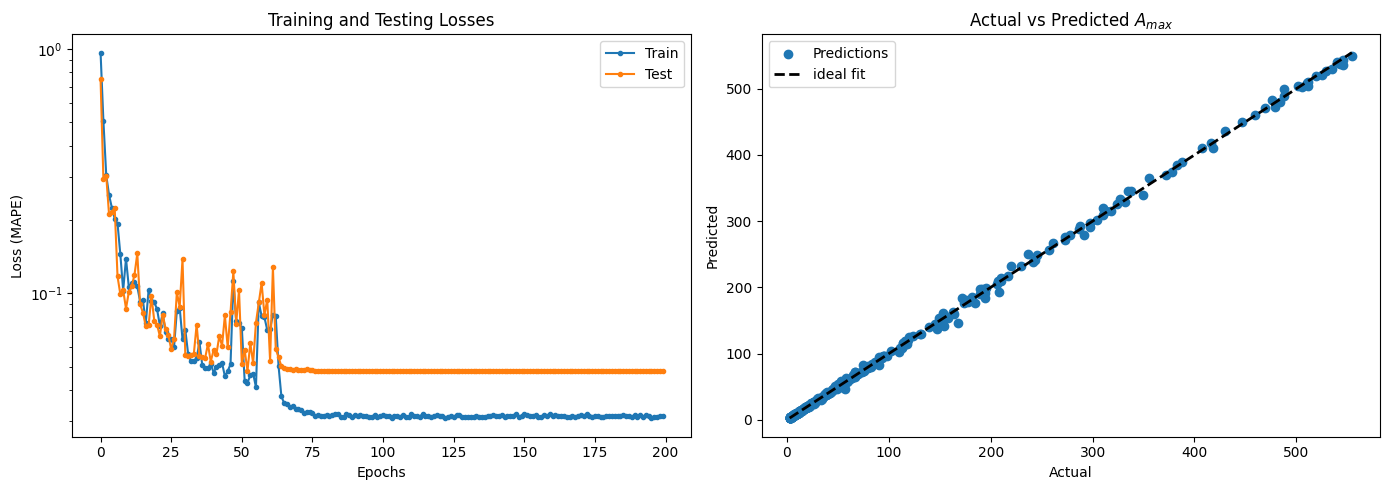

In [49]:
model_name = 'sym_cnn2'
results[model_name] = train(train_dataset, test_dataset,
                                model=make_model2(),
                                loss_fn=RMSPE(),
                                num_epochs=200,
                                batch_size=128,
                                learning_rate=1e-2,
                                early_stop=-50,
                                verbosity=-1)

results[model_name]['y_pred'] = predict(results[model_name]['model'], test_dataset.features)

plot_losses_and_predictions(results[model_name]['train_hist'], results[model_name]['val_hist'],
                            test_dataset.targets, results[model_name]['y_pred'])